## Dota Match Prediction Project

- Source/Credit: The data for this project comes from a Kaggle dataset last updated 1 year ago by Devin Anzelmo.
- The dataset is available on Kaggle at: https://www.kaggle.com/devinanzelmo/dota-2-matches

In [1]:
# Importing the libraries:
import pandas as pd
import numpy as np
from math import sqrt
from scipy import stats

# visualizing
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# plt.rc('figure', figsize=(13, 10))
# plt.rc('font', size=14)

# preparing
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# modeling and evaluating
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix

# turn off warnings
import warnings
warnings.filterwarnings("ignore")

# acquiring
from pydataset import data

## Acquire

In [2]:
players = pd.read_csv("data/players.csv")
match = pd.read_csv("data/match.csv")
heroes = pd.read_csv("data/hero_names.csv")
items = pd.read_csv("data/item_ids.csv")
test_player = pd.read_csv("data/test_player.csv")
test_label = pd.read_csv("data/test_labels.csv")

In [3]:
# Additional data to be joined (as needed):

# outcomes = pd.read_csv("data/match_outcomes.csv")
# player_rating = pd.read_csv("data/player_ratings.csv")
objectives = pd.read_csv("data/objectives.csv")

In [4]:
players.hero_id.value_counts().head(10)

21     20881
11     17007
74     11676
7      11323
28     11181
39     10590
8      10394
100    10306
73      9823
14      9447
Name: hero_id, dtype: int64

In [5]:
# Taking a quick look at the top 5 heroes picked:

# heroes[(heroes.hero_id == 21) | (heroes.hero_id == 11) | (heroes.hero_id == 74) | (heroes.hero_id == 7) | (heroes.hero_id == 28)]
top_ten = [21, 11, 74, 7, 28, 39, 8, 100, 73, 14]
heroes[heroes.hero_id.isin(top_ten)]

,name,hero_id,localized_name
6,npc_dota_hero_earthshaker,7,Earthshaker
7,npc_dota_hero_juggernaut,8,Juggernaut
10,npc_dota_hero_nevermore,11,Shadow Fiend
13,npc_dota_hero_pudge,14,Pudge
20,npc_dota_hero_windrunner,21,Windranger
26,npc_dota_hero_slardar,28,Slardar
37,npc_dota_hero_queenofpain,39,Queen of Pain
71,npc_dota_hero_alchemist,73,Alchemist
72,npc_dota_hero_invoker,74,Invoker
98,npc_dota_hero_tusk,100,Tusk


#### Takeaways:

- I've discovered the top 5 most often picked heroes
- I still need to answer the questions posed in my prep section below..

#### Removing the 37 rows that don't have any hero_ids attached to them.
- In the interest of time, I'm simply going to drop these 27 rows out of 500,000.

In [6]:
# Dropping hero_id == 0
player = players.copy()
players = players[players.hero_id != 0]
players.shape, player.shape

((499963, 73), (500000, 73))

## Prep

- Key points I need to answer:
    - What is the time scale? I think it's either in seconds or minutes. Probably seconds.
    - How is 'player skill' determined, and is there a better set of features to create a "player skill" feature?
    - I need to join these tables; are there different types of data; ie, are there time-series tables vs statis tables I need to make sure I'm not mixing/matching?
    - Is there a specific combination of heroes and items that makes for a match-winning combination? That's the goal, so how to I prep the data to get those features in a df?
    

In [7]:
# First off, need to join the heroes df to my players df so that I have all the names of the heroes together.

In [8]:
# Checking first that there are no nulls 
players[players.hero_id.isna()]

,match_id,account_id,hero_id,player_slot,gold,gold_spent,gold_per_min,xp_per_min,kills,deaths,...,unit_order_glyph,unit_order_eject_item_from_stash,unit_order_cast_rune,unit_order_ping_ability,unit_order_move_to_direction,unit_order_patrol,unit_order_vector_target_position,unit_order_radar,unit_order_set_item_combine_lock,unit_order_continue


In [9]:
# Now need to add the list of heroes full names to main df:

In [10]:
player_heroes = pd.merge(players, heroes, left_on = 'hero_id', right_on = 'hero_id', how = 'left')
player_heroes.head()

,match_id,account_id,hero_id,player_slot,gold,gold_spent,gold_per_min,xp_per_min,kills,deaths,...,unit_order_cast_rune,unit_order_ping_ability,unit_order_move_to_direction,unit_order_patrol,unit_order_vector_target_position,unit_order_radar,unit_order_set_item_combine_lock,unit_order_continue,name,localized_name
0,0,0,86,0,3261,10960,347,362,9,3,...,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,npc_dota_hero_rubick,Rubick
1,0,1,51,1,2954,17760,494,659,13,3,...,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,npc_dota_hero_rattletrap,Clockwerk
2,0,0,83,2,110,12195,350,385,0,4,...,NaN,17.0,NaN,NaN,NaN,NaN,NaN,NaN,npc_dota_hero_treant,Treant Protector
3,0,2,11,3,1179,22505,599,605,8,4,...,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,npc_dota_hero_nevermore,Shadow Fiend
4,0,3,67,4,3307,23825,613,762,20,3,...,NaN,23.0,NaN,NaN,NaN,NaN,NaN,NaN,npc_dota_hero_spectre,Spectre


In [11]:
player_heroes.drop(columns = ['name'], inplace = True)
player_heroes.rename(columns = {"localized_name": "hero"}, inplace = True)

In [12]:
player_heroes[player_heroes.hero_id != 0]

,match_id,account_id,hero_id,player_slot,gold,gold_spent,gold_per_min,xp_per_min,kills,deaths,...,unit_order_eject_item_from_stash,unit_order_cast_rune,unit_order_ping_ability,unit_order_move_to_direction,unit_order_patrol,unit_order_vector_target_position,unit_order_radar,unit_order_set_item_combine_lock,unit_order_continue,hero
0,0,0,86,0,3261,10960,347,362,9,3,...,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,Rubick
1,0,1,51,1,2954,17760,494,659,13,3,...,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,Clockwerk
2,0,0,83,2,110,12195,350,385,0,4,...,NaN,NaN,17.0,NaN,NaN,NaN,NaN,NaN,NaN,Treant Protector
3,0,2,11,3,1179,22505,599,605,8,4,...,NaN,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,Shadow Fiend
4,0,3,67,4,3307,23825,613,762,20,3,...,NaN,NaN,23.0,NaN,NaN,NaN,NaN,NaN,NaN,Spectre
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499958,49999,0,100,128,2718,17735,468,626,16,9,...,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,Tusk
499959,49999,0,9,129,3755,20815,507,607,12,6,...,NaN,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN,Mirana
499960,49999,0,90,130,1059,16225,371,404,5,3,...,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,Keeper of the Light
499961,49999,0,73,131,3165,31015,780,703,8,6,...,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Alchemist


In [13]:
player_heroes.head(20)

,match_id,account_id,hero_id,player_slot,gold,gold_spent,gold_per_min,xp_per_min,kills,deaths,...,unit_order_eject_item_from_stash,unit_order_cast_rune,unit_order_ping_ability,unit_order_move_to_direction,unit_order_patrol,unit_order_vector_target_position,unit_order_radar,unit_order_set_item_combine_lock,unit_order_continue,hero
0,0,0,86,0,3261,10960,347,362,9,3,...,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,Rubick
1,0,1,51,1,2954,17760,494,659,13,3,...,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,Clockwerk
2,0,0,83,2,110,12195,350,385,0,4,...,NaN,NaN,17.0,NaN,NaN,NaN,NaN,NaN,NaN,Treant Protector
3,0,2,11,3,1179,22505,599,605,8,4,...,NaN,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,Shadow Fiend
4,0,3,67,4,3307,23825,613,762,20,3,...,NaN,NaN,23.0,NaN,NaN,NaN,NaN,NaN,NaN,Spectre
5,0,4,106,128,476,12285,397,524,5,6,...,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,Ember Spirit
6,0,0,102,129,317,10355,303,369,4,13,...,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,Abaddon
7,0,5,46,130,2390,13395,452,517,4,8,...,NaN,NaN,4.0,110.0,NaN,NaN,NaN,NaN,NaN,Templar Assassin
8,0,0,7,131,475,5035,189,223,1,14,...,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Earthshaker
9,0,6,73,132,60,17550,496,456,1,11,...,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,Alchemist


In [14]:
# What was I thinking... use gold, and gold_per_min as one of my main features for predicting a win...
# So groupby team per match; what was the team's total gold, and what was the team's avg gold_per_min.

In [15]:
player_heroes.apply(lambda x: (x == 0).sum(), axis = 'columns')

0         5
1         3
2         5
3         2
4         3
         ..
499958    4
499959    3
499960    2
499961    3
499962    3
Length: 499963, dtype: int64

In [16]:
item_counts = player_heroes[['item_0', 'item_1', 'item_2', 'item_3', 'item_4', 'item_5']]
item_counts.head()
item_counts.shape

(499963, 6)

In [17]:
item_counts['item_total'] = item_counts.apply(lambda x: (x > 0).sum(), axis = 'columns')
item_counts

,item_0,item_1,item_2,item_3,item_4,item_5,item_total
0,180,37,73,56,108,0,5
1,46,63,119,102,24,108,6
2,48,60,59,108,65,0,5
3,63,147,154,164,79,160,6
4,114,92,147,0,137,63,5
...,...,...,...,...,...,...,...
499958,249,41,0,50,141,168,5
499959,135,63,166,30,36,139,6
499960,79,48,152,108,102,117,6
499961,249,154,112,48,114,137,6


In [18]:
# I will join this total column to the clean main df below

In [19]:
player_heroes.columns.tolist()

['match_id',
 'account_id',
 'hero_id',
 'player_slot',
 'gold',
 'gold_spent',
 'gold_per_min',
 'xp_per_min',
 'kills',
 'deaths',
 'assists',
 'denies',
 'last_hits',
 'stuns',
 'hero_damage',
 'hero_healing',
 'tower_damage',
 'item_0',
 'item_1',
 'item_2',
 'item_3',
 'item_4',
 'item_5',
 'level',
 'leaver_status',
 'xp_hero',
 'xp_creep',
 'xp_roshan',
 'xp_other',
 'gold_other',
 'gold_death',
 'gold_buyback',
 'gold_abandon',
 'gold_sell',
 'gold_destroying_structure',
 'gold_killing_heros',
 'gold_killing_creeps',
 'gold_killing_roshan',
 'gold_killing_couriers',
 'unit_order_none',
 'unit_order_move_to_position',
 'unit_order_move_to_target',
 'unit_order_attack_move',
 'unit_order_attack_target',
 'unit_order_cast_position',
 'unit_order_cast_target',
 'unit_order_cast_target_tree',
 'unit_order_cast_no_target',
 'unit_order_cast_toggle',
 'unit_order_hold_position',
 'unit_order_train_ability',
 'unit_order_drop_item',
 'unit_order_give_item',
 'unit_order_pickup_item',
 

#### Dropping unneeded columns

- Since the point of this modeling is going to revovle around directly modeling heroes and items, I don't need columns that are only indirectly related to those potential features. Thus, I'm going to drop any mention of `unit_order` or `gold` in my columns. Need to get the dataframe down to a more manageable size.

In [20]:
# Instead of dropping columns, I'm simply assigning the columns I want to keep:

player_heroes_cleaned = player_heroes[['match_id', 'account_id', 'hero_id', 'hero', 'player_slot', 'gold_per_min', 
                                       'kills', 'deaths', 'assists', 'denies', 'last_hits']]

In [21]:
columns_reduced = player_heroes.shape[1] - player_heroes_cleaned.shape[1]
print(f'Reduced the number of columns by {columns_reduced}.')

Reduced the number of columns by 63.


In [22]:
player_heroes_cleaned.shape, item_counts.shape

((499963, 11), (499963, 7))

In [23]:
df = pd.merge(player_heroes_cleaned, item_counts, left_index = True, right_index = True, how = 'left')
df.head()

,match_id,account_id,hero_id,hero,player_slot,gold_per_min,kills,deaths,assists,denies,last_hits,item_0,item_1,item_2,item_3,item_4,item_5,item_total
0,0,0,86,Rubick,0,347,9,3,18,1,30,180,37,73,56,108,0,5
1,0,1,51,Clockwerk,1,494,13,3,18,9,109,46,63,119,102,24,108,6
2,0,0,83,Treant Protector,2,350,0,4,15,1,58,48,60,59,108,65,0,5
3,0,2,11,Shadow Fiend,3,599,8,4,19,6,271,63,147,154,164,79,160,6
4,0,3,67,Spectre,4,613,20,3,17,13,245,114,92,147,0,137,63,5


In [25]:
df.drop(columns = ['item_0', 'item_0', 'item_1', 'item_2', 'item_3', 'item_4', 'item_5'], inplace = True)
df.head()

,match_id,account_id,hero_id,hero,player_slot,gold_per_min,kills,deaths,assists,denies,last_hits,item_total
0,0,0,86,Rubick,0,347,9,3,18,1,30,5
1,0,1,51,Clockwerk,1,494,13,3,18,9,109,6
2,0,0,83,Treant Protector,2,350,0,4,15,1,58,5
3,0,2,11,Shadow Fiend,3,599,8,4,19,6,271,6
4,0,3,67,Spectre,4,613,20,3,17,13,245,5


In [26]:
# Now I need to create dummies for each hero name, then I can groupby team

In [27]:
player_combos = pd.get_dummies(player_heroes_cleaned['hero'])
player_combos.head()

,Abaddon,Alchemist,Ancient Apparition,Anti-Mage,Axe,Bane,Batrider,Beastmaster,Bloodseeker,Bounty Hunter,...,Venomancer,Viper,Visage,Warlock,Weaver,Windranger,Winter Wyvern,Witch Doctor,Wraith King,Zeus
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# item0 = pd.get_dummies(players['item_0'].fillna(0))
# item1 = pd.get_dummies(players['item_1'].fillna(0))
# item2 = pd.get_dummies(players['item_2'].fillna(0))
# item3 = pd.get_dummies(players['item_3'].fillna(0))
# item4 = pd.get_dummies(players['item_4'].fillna(0))
# item5 = pd.get_dummies(players['item_5'].fillna(0))

In [28]:
matches = match.copy()
matches.columns

Index(['match_id', 'start_time', 'duration', 'tower_status_radiant',
       'tower_status_dire', 'barracks_status_dire', 'barracks_status_radiant',
       'first_blood_time', 'game_mode', 'radiant_win', 'negative_votes',
       'positive_votes', 'cluster'],
      dtype='object')

In [29]:
match_result = matches[['match_id', 'radiant_win']]

In [30]:
dota_df = pd.merge(df, match_result, left_on = 'match_id', right_on = 'match_id', how = 'left')
dota_df.head()

,match_id,account_id,hero_id,hero,player_slot,gold_per_min,kills,deaths,assists,denies,last_hits,item_total,radiant_win
0,0,0,86,Rubick,0,347,9,3,18,1,30,5,True
1,0,1,51,Clockwerk,1,494,13,3,18,9,109,6,True
2,0,0,83,Treant Protector,2,350,0,4,15,1,58,5,True
3,0,2,11,Shadow Fiend,3,599,8,4,19,6,271,6,True
4,0,3,67,Spectre,4,613,20,3,17,13,245,5,True


In [31]:
# dota_df[dota_df.match_id == 0]

In [32]:
# dota_df['top_ten_hero'] = dota_df.hero_id.isin(top_ten).astype(int)
# dota_df.head()

# Carving off needed columns for actual train/validate/test dataframe

In [33]:
dota = dota_df[['match_id', 'account_id', 'player_slot', 'hero_id', 'hero', 'gold_per_min', 'kills', 'deaths', 'assists', 'denies', 'last_hits', 'item_total', 'radiant_win']]
dota.head()

,match_id,account_id,player_slot,hero_id,hero,gold_per_min,kills,deaths,assists,denies,last_hits,item_total,radiant_win
0,0,0,0,86,Rubick,347,9,3,18,1,30,5,True
1,0,1,1,51,Clockwerk,494,13,3,18,9,109,6,True
2,0,0,2,83,Treant Protector,350,0,4,15,1,58,5,True
3,0,2,3,11,Shadow Fiend,599,8,4,19,6,271,6,True
4,0,3,4,67,Spectre,613,20,3,17,13,245,5,True


### Creating a target variable

I have to create a new y, or target variable that actually matches up with the winning team. In other words, the original dataset didn't clearly dictate which team was radiant and which team was dire, so I couldn't tell which teams

In [34]:
dota['is_radiant'] = pd.cut(dota.player_slot, bins = [-1,100,200], labels = [1, 0])

In [35]:
dota.groupby(['is_radiant', 'radiant_win'])['kills'].mean()

is_radiant  radiant_win
1           False          5.939393
            True           8.745035
0           False          9.142906
            True           5.812356
Name: kills, dtype: float64

In [36]:
dota.groupby(['is_radiant', 'radiant_win'])['kills'].median()

is_radiant  radiant_win
1           False          5
            True           8
0           False          8
            True           5
Name: kills, dtype: int64

In [37]:
# I can also verify with elims, last_hits, etc...

In [38]:
dota['radiant_win'] = dota.radiant_win.astype(int)

In [39]:
dota['win'] = dota.radiant_win == dota.is_radiant

In [40]:
dota.win.value_counts(normalize = True)

True     0.500025
False    0.499975
Name: win, dtype: float64

In [41]:
dota['win'] = dota.win.astype(int)

In [42]:
dota.head(20)

,match_id,account_id,player_slot,hero_id,hero,gold_per_min,kills,deaths,assists,denies,last_hits,item_total,radiant_win,is_radiant,win
0,0,0,0,86,Rubick,347,9,3,18,1,30,5,1,1,1
1,0,1,1,51,Clockwerk,494,13,3,18,9,109,6,1,1,1
2,0,0,2,83,Treant Protector,350,0,4,15,1,58,5,1,1,1
3,0,2,3,11,Shadow Fiend,599,8,4,19,6,271,6,1,1,1
4,0,3,4,67,Spectre,613,20,3,17,13,245,5,1,1,1
5,0,4,128,106,Ember Spirit,397,5,6,8,5,162,5,1,0,0
6,0,0,129,102,Abaddon,303,4,13,5,2,107,6,1,0,0
7,0,5,130,46,Templar Assassin,452,4,8,6,31,208,6,1,0,0
8,0,0,131,7,Earthshaker,189,1,14,8,0,27,3,1,0,0
9,0,6,132,73,Alchemist,496,1,11,6,0,147,6,1,0,0


In [43]:
# Final cleanup of hero column:

dota['hero'] = dota['hero'].str.lower()

In [44]:
dota_dummy = pd.get_dummies(dota[['hero']], dummy_na = False)
dota_dummy

,hero_abaddon,hero_alchemist,hero_ancient apparition,hero_anti-mage,hero_axe,hero_bane,hero_batrider,hero_beastmaster,hero_bloodseeker,hero_bounty hunter,...,hero_venomancer,hero_viper,hero_visage,hero_warlock,hero_weaver,hero_windranger,hero_winter wyvern,hero_witch doctor,hero_wraith king,hero_zeus
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499958,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
499959,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
499960,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
499961,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
dota = pd.concat([dota, dota_dummy], axis = 1)
dota.head()

,match_id,account_id,player_slot,hero_id,hero,gold_per_min,kills,deaths,assists,denies,...,hero_venomancer,hero_viper,hero_visage,hero_warlock,hero_weaver,hero_windranger,hero_winter wyvern,hero_witch doctor,hero_wraith king,hero_zeus
0,0,0,0,86,rubick,347,9,3,18,1,...,0,0,0,0,0,0,0,0,0,0
1,0,1,1,51,clockwerk,494,13,3,18,9,...,0,0,0,0,0,0,0,0,0,0
2,0,0,2,83,treant protector,350,0,4,15,1,...,0,0,0,0,0,0,0,0,0,0
3,0,2,3,11,shadow fiend,599,8,4,19,6,...,0,0,0,0,0,0,0,0,0,0
4,0,3,4,67,spectre,613,20,3,17,13,...,0,0,0,0,0,0,0,0,0,0


In [46]:
dota.drop(columns = ['hero_id', 'radiant_win', 'hero'], inplace = True)
dota.head()

,match_id,account_id,player_slot,gold_per_min,kills,deaths,assists,denies,last_hits,item_total,...,hero_venomancer,hero_viper,hero_visage,hero_warlock,hero_weaver,hero_windranger,hero_winter wyvern,hero_witch doctor,hero_wraith king,hero_zeus
0,0,0,0,347,9,3,18,1,30,5,...,0,0,0,0,0,0,0,0,0,0
1,0,1,1,494,13,3,18,9,109,6,...,0,0,0,0,0,0,0,0,0,0
2,0,0,2,350,0,4,15,1,58,5,...,0,0,0,0,0,0,0,0,0,0
3,0,2,3,599,8,4,19,6,271,6,...,0,0,0,0,0,0,0,0,0,0
4,0,3,4,613,20,3,17,13,245,5,...,0,0,0,0,0,0,0,0,0,0


## I need to come back and scale the kills, deaths, and k_d once I figure out how to. **But right now, it's a race to the MVP finish line.**

In [47]:
dota.columns.tolist()

['match_id',
 'account_id',
 'player_slot',
 'gold_per_min',
 'kills',
 'deaths',
 'assists',
 'denies',
 'last_hits',
 'item_total',
 'is_radiant',
 'win',
 'hero_abaddon',
 'hero_alchemist',
 'hero_ancient apparition',
 'hero_anti-mage',
 'hero_axe',
 'hero_bane',
 'hero_batrider',
 'hero_beastmaster',
 'hero_bloodseeker',
 'hero_bounty hunter',
 'hero_brewmaster',
 'hero_bristleback',
 'hero_broodmother',
 'hero_centaur warrunner',
 'hero_chaos knight',
 'hero_chen',
 'hero_clinkz',
 'hero_clockwerk',
 'hero_crystal maiden',
 'hero_dark seer',
 'hero_dazzle',
 'hero_death prophet',
 'hero_disruptor',
 'hero_doom',
 'hero_dragon knight',
 'hero_drow ranger',
 'hero_earth spirit',
 'hero_earthshaker',
 'hero_elder titan',
 'hero_ember spirit',
 'hero_enchantress',
 'hero_enigma',
 'hero_faceless void',
 'hero_gyrocopter',
 'hero_huskar',
 'hero_invoker',
 'hero_io',
 'hero_jakiro',
 'hero_juggernaut',
 'hero_keeper of the light',
 'hero_kunkka',
 'hero_legion commander',
 'hero_leshra

Now I should be done with all the data prep; I have my indepdendent variables, and my target variable, the `win` column, which has also been encoded.

### Splitting into Train, Validate, and Test

So that I can explore using train.

In [48]:
def df_split(df):
    train_validate, test = train_test_split(df, test_size=.2, random_state=123, stratify=df.win)
    train, validate = train_test_split(train_validate, test_size=.3, random_state=123, stratify=train_validate.win)
    return train, validate, test

In [49]:
train, validate, test = df_split(dota)
print(train.shape, validate.shape, test.shape)

(279979, 122) (119991, 122) (99993, 122)


In [50]:
train.win.value_counts(normalize = True), dota.win.value_counts(normalize = True)

(1    0.500027
 0    0.499973
 Name: win, dtype: float64,
 1    0.500025
 0    0.499975
 Name: win, dtype: float64)

In [51]:
train.columns.tolist()

['match_id',
 'account_id',
 'player_slot',
 'gold_per_min',
 'kills',
 'deaths',
 'assists',
 'denies',
 'last_hits',
 'item_total',
 'is_radiant',
 'win',
 'hero_abaddon',
 'hero_alchemist',
 'hero_ancient apparition',
 'hero_anti-mage',
 'hero_axe',
 'hero_bane',
 'hero_batrider',
 'hero_beastmaster',
 'hero_bloodseeker',
 'hero_bounty hunter',
 'hero_brewmaster',
 'hero_bristleback',
 'hero_broodmother',
 'hero_centaur warrunner',
 'hero_chaos knight',
 'hero_chen',
 'hero_clinkz',
 'hero_clockwerk',
 'hero_crystal maiden',
 'hero_dark seer',
 'hero_dazzle',
 'hero_death prophet',
 'hero_disruptor',
 'hero_doom',
 'hero_dragon knight',
 'hero_drow ranger',
 'hero_earth spirit',
 'hero_earthshaker',
 'hero_elder titan',
 'hero_ember spirit',
 'hero_enchantress',
 'hero_enigma',
 'hero_faceless void',
 'hero_gyrocopter',
 'hero_huskar',
 'hero_invoker',
 'hero_io',
 'hero_jakiro',
 'hero_juggernaut',
 'hero_keeper of the light',
 'hero_kunkka',
 'hero_legion commander',
 'hero_leshra

In [53]:
X_train = train.drop(columns = ['match_id',
                                     'account_id',
                                     'player_slot',
                                     'is_radiant',
                                     'win'])
y_train = train[['win']]

# Validate dataset features:
X_validate = validate.drop(columns = ['match_id',
                                         'account_id',
                                         'player_slot',
                                         'is_radiant',
                                         'win'])
y_validate = validate[['win']]

# Test dataset features:
X_test = test.drop(columns = ['match_id',
                                 'account_id',
                                 'player_slot',
                                 'is_radiant',
                                 'win'])
y_test = test[['win']]

In [64]:
X_train.shape, X_validate.shape, X_test.shape

((279979, 117), (119991, 117), (99993, 117))

In [55]:
# x_train_and_validate, x_test = train_test_split(X, random_state=123)
# x_train, x_validate = train_test_split(x_train_and_validate)

In [66]:
# Scaling the data:

scaler = sklearn.preprocessing.MinMaxScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_validate_scaled = scaler.transform(X_validate)
X_test_scaled = scaler.transform(X_test)

In [67]:
X_validate_scaled.shape

(119991, 117)

In [70]:
# Turning the scaled data back into dataframes:


X_train_scaled = pd.DataFrame(X_train_scaled, 
                            columns=X_train.columns.values).\
                            set_index([X_train.index.values])

X_validate_scaled = pd.DataFrame(X_validate_scaled, 
                                columns=X_validate.columns.values).\
                            set_index([X_validate.index.values])

X_test_scaled = pd.DataFrame(X_test_scaled, 
                                columns=X_test.columns.values).\
                            set_index([X_test.index.values])

In [72]:
X_train_scaled

,gold_per_min,kills,deaths,assists,denies,last_hits,item_total,hero_abaddon,hero_alchemist,hero_ancient apparition,...,hero_venomancer,hero_viper,hero_visage,hero_warlock,hero_weaver,hero_windranger,hero_winter wyvern,hero_witch doctor,hero_wraith king,hero_zeus
191915,0.138574,0.152542,0.238095,0.129630,0.000000,0.0170,1.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36408,0.211193,0.067797,0.214286,0.203704,0.080357,0.0835,1.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12827,0.110593,0.067797,0.119048,0.148148,0.053571,0.0475,0.833333,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
336629,0.169887,0.101695,0.095238,0.129630,0.008929,0.0165,0.833333,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30884,0.299134,0.220339,0.142857,0.333333,0.008929,0.0460,1.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
448474,0.196536,0.135593,0.357143,0.314815,0.008929,0.0910,0.833333,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
264983,0.179214,0.084746,0.142857,0.240741,0.008929,0.0305,0.666667,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
300127,0.171885,0.084746,0.309524,0.166667,0.026786,0.0350,0.833333,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
338402,0.291805,0.118644,0.119048,0.074074,0.151786,0.2615,1.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [88]:
# Grouping by team per match:

dota.groupby("match_id").mean()

,account_id,player_slot,gold_per_min,kills,deaths,assists,denies,last_hits,item_total,win,...,hero_venomancer,hero_viper,hero_visage,hero_warlock,hero_weaver,hero_windranger,hero_winter wyvern,hero_witch doctor,hero_wraith king,hero_zeus
match_id,,,,,,,,,,,,,,,,,,,,,
0,2.1,66.0,424.0,6.5,6.9,12.0,6.8,136.4,5.3,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.3,66.0,475.4,8.5,9.0,13.2,4.3,174.5,5.0,0.5,...,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.1
2,4.6,66.0,345.2,7.0,7.1,12.1,2.6,119.8,5.3,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11.9,66.0,411.7,12.7,13.1,20.2,6.1,120.6,5.1,0.5,...,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,17.3,66.0,435.6,5.3,5.3,8.9,4.7,103.7,5.6,0.5,...,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,50654.2,66.0,409.7,8.8,9.1,11.4,3.8,145.5,5.1,0.5,...,0.0,0.0,0.0,0.0,0.0,0.1,0.1,0.0,0.0,0.0
49996,47836.8,66.0,406.4,5.4,5.5,9.3,4.5,66.9,5.0,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0
49997,54438.0,66.0,416.5,8.5,8.6,14.4,6.5,140.9,5.8,0.5,...,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0


In [158]:
# df for exploration:

df_explore = train[['match_id',
                     'account_id',
                     'player_slot',
                     'gold_per_min',
                     'kills',
                     'deaths',
                     'assists',
                     'denies',
                     'last_hits',
                     'item_total',
                     'is_radiant',
                     'win','gold_rate',
                     'item_bins']
                  ]
df_explore.head()

,match_id,account_id,player_slot,gold_per_min,kills,deaths,assists,denies,last_hits,item_total,is_radiant,win,gold_rate,item_bins
191915,19192,8839,130,308,9,10,7,0,34,6,0,0,Low,Full
36408,3641,0,4,417,4,9,11,9,167,6,1,1,High,Full
12827,1283,6348,0,266,4,5,8,6,95,5,1,0,Low,High
336629,33665,0,2,355,6,4,7,1,33,5,1,1,Medium,High
30884,3089,0,0,549,13,6,18,1,92,6,1,1,High,Full


## Explore

Questions I would like to answer:

- Is there a common item bought be winning teams?
- Is there a common set of items bought by winning teams?
- Is there an average player skill level distinct to winning teams (hypo t-test...?)
- Are there player K/D ratios that lead to higher win %?
- Do the Raidient vs Dire teams win more? Is that random or something that a feature that can be developed from team?
- Create visuals of most popular heroes picked over time = 2012 - 2015.
- If I can get more data from Opendota api, add to already existsing data.

#### Hypotheses:

1.  Does the mean 

#### Other things to explore:

- Which heroes have a low pick % but a high win %, so in other words.
- A high win rate for a hero is > 50%. They spend a lot of time trying to balance the game.
- Look at Dotabuff/Dota Plus. It'll give some good player pick vs. win rate.
- How do I want to visualize "winning"? Do I wanna consider a radient win as a "win"?
- I think my baseline should be radient wins overall; that would be an interesting baseline to use...


## Hypothesis Testing:


#### Hypothesis 1:
- $H_0$: The average `gold_per_min` for the winning team is not different than the average `gold_per_min` of the losing team
- $H_a$: The average `gold_per_min` rate for the winning team is statistically different than the average `gold_per_min` of the losing team

#### Hypothesis 2: Using a $X^2$ Test
- $H_0$: The average number of items a team has has no impact (is independent of) the team's outcome in the match (whether that team wins or loses).

- $H_a$: The average number of items a team has *does* have an impact (is not independent of) the team's outcome in the match.

In [150]:

# Setting overall confidence and alpha levels for all testing. My alpha level will not change past this point, regardless of what my models show.

confidence_level = .95
alpha = round(1 - confidence_level, 2)
alpha

0.05

### Hypothesis Test #1:

- $H_0$: The average `gold_per_min` for the winning team is not different than the average `gold_per_min` of the losing team
- $H_a$: The average `gold_per_min` rate for the winning team is statistically different than the average `gold_per_min` of the losing team


In [157]:
df_explore.groupby("win").gold_per_min.agg(['min', 'max', 'mean']).round(2)

,min,max,mean
win,,,
0,100,1468,349.05
1,123,1601,480.79


In [174]:
# Creating variables to hold my 
gold_win_test = df_explore[df_explore.win == 1].gold_per_min
gold_loss_test = df_explore[df_explore.win == 0].gold_per_min

# check the variances
print(gold_win_test.var())
print(gold_loss_test.var())

18064.26043535433
11349.052576909216


In [175]:
# large variance so set equal_var flag to Flase
t, p = stats.ttest_ind(gold_win_test, gold_loss_test, equal_var = False)
t, p/2

(287.3920955979, 0.0)

In [176]:
if p < alpha:
    print("Our p-value is less than our alpha, thus the null hypothesis is rejected.")
else:
    print("Our p-value is greater than our alpha, thus we fail to reject the null hypothesis ")

Our p-value is less than our alpha, thus the null hypothesis is rejected.


<AxesSubplot:>

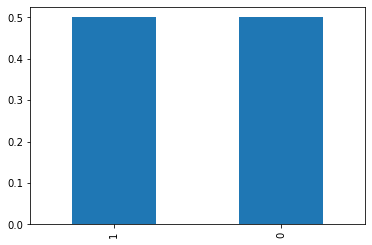

In [73]:
# Baseline model: Radiant team wins just over 50% of the time.


train.win.value_counts(normalize = True).plot(kind = "bar")

In [110]:
# Heatmap:

train.head()

,match_id,account_id,player_slot,gold_per_min,kills,deaths,assists,denies,last_hits,item_total,...,hero_venomancer,hero_viper,hero_visage,hero_warlock,hero_weaver,hero_windranger,hero_winter wyvern,hero_witch doctor,hero_wraith king,hero_zeus
191915,19192,8839,130,308,9,10,7,0,34,6,...,0,0,0,0,0,0,0,0,0,0
36408,3641,0,4,417,4,9,11,9,167,6,...,0,0,0,0,0,0,0,0,0,0
12827,1283,6348,0,266,4,5,8,6,95,5,...,0,0,0,0,0,0,0,0,0,0
336629,33665,0,2,355,6,4,7,1,33,5,...,0,0,0,0,0,0,0,0,0,0
30884,3089,0,0,549,13,6,18,1,92,6,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:xlabel='is_radiant', ylabel='gold_per_min'>

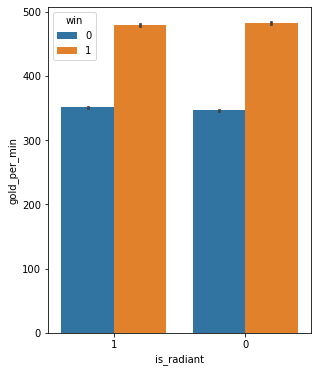

In [112]:
plt.figure(figsize = (16,6))

plt.subplot(131)
sns.barplot(data = train, y = 'gold_per_min', x = 'is_radiant', hue = 'win')


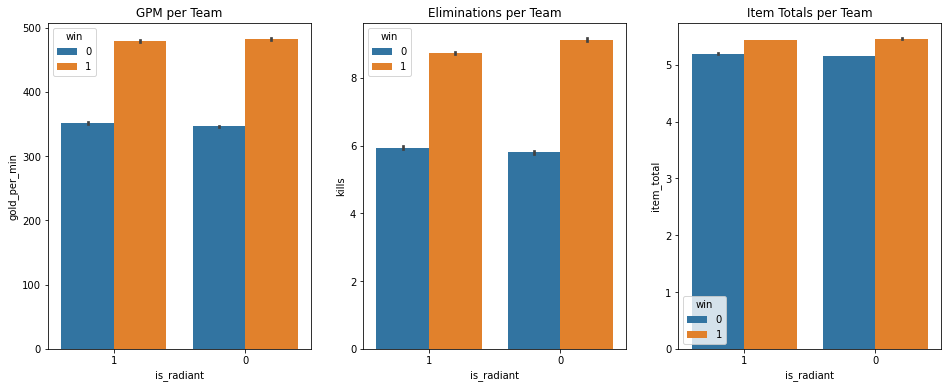

In [149]:
plt.figure(figsize = (16,6))

plt.subplot(131)
sns.barplot(data = train, y = 'gold_per_min', x = 'is_radiant', hue = 'win')
plt.title("GPM per Team")

plt.subplot(132)
sns.barplot(data = train, y = 'kills', x = 'is_radiant', hue = 'win')
plt.title("Eliminations per Team")

plt.subplot(133)
sns.barplot(data = train, y = 'item_total', x = 'is_radiant', hue = 'win')
plt.title("Item Totals per Team")

plt.show()

In [125]:
# dota['is_radiant'] = pd.cut(dota.player_slot, bins = [-1,100,200], labels = [1, 0])

train.gold_per_min.describe()

count    279979.000000
mean        414.923776
std         138.004462
min         100.000000
25%         317.000000
50%         395.000000
75%         495.000000
max        1601.000000
Name: gold_per_min, dtype: float64

In [134]:
# Binning the gold earned per min:
train['gold_rate'] = pd.cut(train.gold_per_min, bins = [0,325,400,550,1650], labels = ["Low", "Medium", "High", "Extreme"])
train.head()

,match_id,account_id,player_slot,gold_per_min,kills,deaths,assists,denies,last_hits,item_total,...,hero_viper,hero_visage,hero_warlock,hero_weaver,hero_windranger,hero_winter wyvern,hero_witch doctor,hero_wraith king,hero_zeus,gold_rate
191915,19192,8839,130,308,9,10,7,0,34,6,...,0,0,0,0,0,0,0,0,0,Low
36408,3641,0,4,417,4,9,11,9,167,6,...,0,0,0,0,0,0,0,0,0,High
12827,1283,6348,0,266,4,5,8,6,95,5,...,0,0,0,0,0,0,0,0,0,Low
336629,33665,0,2,355,6,4,7,1,33,5,...,0,0,0,0,0,0,0,0,0,Medium
30884,3089,0,0,549,13,6,18,1,92,6,...,0,0,0,0,0,0,0,0,0,High


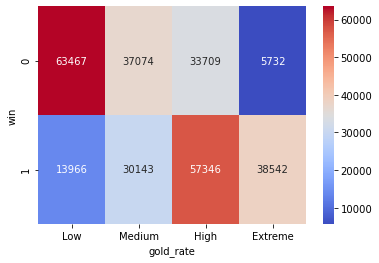

In [135]:
# Using a heatmap to discover if the independent variables I've selected are correlated in any way.

ctab = pd.crosstab(train.win, train['gold_rate'])

sns.heatmap(ctab, annot = True, cmap = 'coolwarm', fmt = 'd')
plt.show()

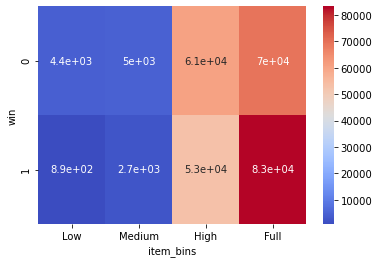

In [145]:
train['item_bins'] = pd.cut(train.item_total, bins = [-1,2,3,5,6], labels = ["Low", "Medium", "High", "Full"])

ctab2 = pd.crosstab(train.win, train['item_bins'])

sns.heatmap(ctab2, annot = True, cmap = 'coolwarm')
plt.show()

### Initial Takeaways:

- It appears that both the number of items and the rate of gold earned, if high, have an effect on the outcome of whether or not a team will win. 
- However, it appears that the gold rate is much more important to the overall outcome than the number of items purchased. So I'll be using the `gold_per_min` feature in my modeling.

### Splitting the data:

In [ ]:
X_train_log = train.drop(columns = ['match_id',
                                     'account_id',
                                     'hero',
                                     'player_slot',
                                     'k_d',
                                     'deaths',
                                     'is_radiant',
                                     'win'])
y_train_log = train[['win']]

# Validate dataset features:
X_validate_log = validate.drop(columns = ['match_id',
                                         'account_id',
                                         'hero',
                                         'player_slot',
                                         'k_d',
                                         'deaths',
                                         'is_radiant',
                                         'win'])
y_validate_log = validate[['win']]

# Test dataset features:
X_test_log = test.drop(columns = ['match_id',
                                 'account_id',
                                 'hero',
                                 'player_slot',
                                 'k_d',
                                 'deaths',
                                 'is_radiant',
                                 'win'])
y_test_log = test[['win']]

# Modeling Stage

In [ ]:
import sklearn.preprocessing

#### Model 1: Logistic Regression

In [74]:
# Modeling practice using Logistic Regression Model, basic hyper-parameters

# Using a logistic regression model first:

# Only fit on my training dataset
logit1 = LogisticRegression(C = 1.0, random_state=123)

# Fitting the data to the train dataset:
logit1.fit(X_train_scaled, y_train)

# Printing the coefficients and intercept of the model:
print('Coefficient: \n', logit1.coef_)
print('Intercept: \n', logit1.intercept_)

# Train data prediction:
y_pred1 = logit1.predict(X_train_scaled)

# Now the est. of churn based on train predict:
y_pred_prob1 = logit1.predict_proba(X_train_scaled)

print('Accuracy of Logistic Classifier on training set: {:.2f}'
     .format(logit1.score(X_train_scaled, y_train)))
print(classification_report(y_train, y_pred1))

Coefficient: 
 [[ 3.93279955e+01 -8.51029036e+00 -7.76692580e+00  9.81405284e+00
  -2.71659486e+00 -2.21618865e+01 -5.10341743e-01  3.07967685e-01
  -6.31195093e+00  6.74380926e-01 -1.58484757e+00  4.20366124e-01
   1.12402592e+00 -1.62573537e-01  2.00115600e-01  8.84324676e-02
  -8.19290480e-01 -3.13763690e-01 -4.71017141e-01 -6.43205084e-02
   1.35694951e-01 -2.60425416e-01  1.12904859e+00 -6.16680128e-02
   1.48999277e-01  1.05431249e+00 -6.14840128e-01  1.62386385e+00
  -3.72713964e-01  8.09026345e-01 -1.62387956e+00 -5.07554353e-01
   2.59969341e-01  1.35555647e-01  2.74100574e-01  6.69559087e-02
  -1.40595209e+00  2.44067453e-01 -5.84022179e-01 -4.80289119e-01
  -9.26717596e-01  7.85112530e-01 -7.43017004e-01  1.05383167e+00
   5.30917347e-01 -8.59831533e-01  8.95472234e-01 -5.39665494e-01
  -2.88245600e-01  9.13942918e-02  1.22120326e+00 -9.17557534e-01
   1.80633428e-01  1.53139650e+00 -1.32488693e+00 -1.13580945e+00
  -3.44750380e-01 -2.71558846e-01 -1.15852695e+00 -5.53170362

#### Model 2: Random Forest Model

In [89]:
from sklearn.ensemble import RandomForestClassifier

In [90]:
X_train_rf = X_train
y_train_rf = y_train

In [92]:
# Using Random Forest Model
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=3, 
                            random_state=123)

# Fitting the model using the train data:
rf.fit(X_train_rf, y_train_rf)

# Making prediction:
y_pred_rf = rf.predict(X_train_rf)

# Estimating the probability of churn using the training dataset:
y_pred_proba_rf = rf.predict_proba(X_train_rf)


print('Accuracy of Random Forest Model on training set: {:.2f}'
     .format(logit1.score(X_train_rf, y_train_rf)))
print(classification_report(y_train_rf, y_pred_rf))

Accuracy of Random Forest Model on training set: 0.50
              precision    recall  f1-score   support

           0       0.75      0.76      0.76    139982
           1       0.76      0.75      0.75    139997

    accuracy                           0.76    279979
   macro avg       0.76      0.76      0.76    279979
weighted avg       0.76      0.76      0.76    279979



#### Model 3: Decision Tree, max depth == 5

In [177]:
# Defining the X and Y variables for my modeling
X_train_dt = X_train
y_train_dt = y_train

# Fitting the DT model:
clf = DecisionTreeClassifier(max_depth=5, random_state=123)
clf.fit(X_train_dt, y_train_dt)

# prediction with training data
y_pred_dt = clf.predict(X_train_dt)
#estimate the probability
y_pred_proba_dt = clf.predict_proba(X_train_dt)

print('Accuracy of Logistic Classifier on training set: {:.2f}'
     .format(clf.score(X_train_dt, y_train_dt)))
print(classification_report(y_train_dt, y_pred_dt))

Accuracy of Logistic Classifier on training set: 0.80
              precision    recall  f1-score   support

           0       0.81      0.79      0.80    139982
           1       0.79      0.82      0.80    139997

    accuracy                           0.80    279979
   macro avg       0.80      0.80      0.80    279979
weighted avg       0.80      0.80      0.80    279979



#### Model 4: Decision Tree, max depth == 10

In [179]:
# Adjusting Hyperparameters of DT Model: 
X_train_dt2 = X_train
y_train_dt2 = y_train


# Fitting the DT model:
clf = DecisionTreeClassifier(max_depth=10, random_state=123)
clf.fit(X_train_dt2, y_train_dt2)

# prediction with training data
y_pred_dt2 = clf.predict(X_train_dt2)
#estimate the probability
y_pred_proba_2 = clf.predict_proba(X_train_dt2)

print('Accuracy of Logistic Classifier on training set: {:.2f}'
     .format(clf.score(X_train_dt2, y_train_dt2)))
print(classification_report(y_train_dt2, y_pred_dt2))

Accuracy of Logistic Classifier on training set: 0.85
              precision    recall  f1-score   support

           0       0.84      0.87      0.85    139982
           1       0.86      0.83      0.85    139997

    accuracy                           0.85    279979
   macro avg       0.85      0.85      0.85    279979
weighted avg       0.85      0.85      0.85    279979



#### Model 5: KNN

In [94]:
from sklearn.neighbors import KNeighborsClassifier

In [184]:
# Trying KNN:

knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')


X_train_knn1 = X_train
y_train_knn1 = y_train

In [101]:
# Fitting the model:
knn.fit(X_train_knn, y_train_knn)

KNeighborsClassifier()

In [103]:
# Getting the score:
knn.score(X_train_knn, y_train_knn)

0.8769336271648945

In [104]:
# predict y values
y_pred_knn = knn.predict(X_train_knn)

In [105]:
y_pred_proba_knn = knn.predict_proba(X_train_knn)

In [106]:
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train_knn, y_train_knn)))


Accuracy of KNN classifier on training set: 0.88


In [108]:
print(confusion_matrix(y_train_knn, y_pred_knn))

[[123326  16656]
 [ 17800 122197]]


In [109]:
print(classification_report(y_train_knn, y_pred_knn))

              precision    recall  f1-score   support

           0       0.87      0.88      0.88    139982
           1       0.88      0.87      0.88    139997

    accuracy                           0.88    279979
   macro avg       0.88      0.88      0.88    279979
weighted avg       0.88      0.88      0.88    279979



### Can we locate an even better value for K?

In [189]:
from sklearn import metrics

In [190]:
# try K=1 through K=25 and record testing accuracy
k_range = range(1, 26)

# We can create Python dictionary using [] or dict()
scores = []

# We use a loop through the range 1 to 26
# We append the scores in the dictionary
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores.append(metrics.accuracy_score(y_test, y_pred))

print(scores)

[0.7890752352664686, 0.7934955446881282, 0.8186573060114208, 0.8215775104257298, 0.8289180242616984, 0.8302181152680688, 0.8330383126818878, 0.8339983798865921, 0.8356684967947756, 0.8357285009950697, 0.8360385226965887, 0.8373386137029593, 0.8371986039022732, 0.8381386697068794, 0.8380186613062914, 0.8386287040092807, 0.8382686788075165, 0.8389987299110938, 0.8388987229106037, 0.8389987299110938, 0.8384786935085456, 0.8391287390117308, 0.839528767013691, 0.8393187523126618, 0.839618773314132]


Text(0, 0.5, 'Testing Accuracy')

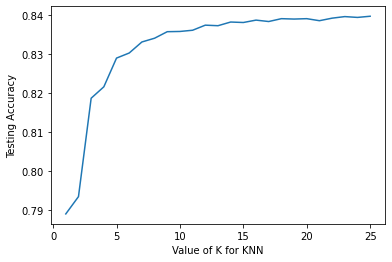

In [191]:
# plot the relationship between K and testing accuracy
# plt.plot(x_axis, y_axis)
plt.plot(k_range, scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

#### Takeaway:
- Testing accuracy decreases as the model complexity rises, as does the test dataset accuracy. 
- The "best" model hyperparameters would be using a higher K value (lower complexity)

#### Train model summary:

Overall Accuracy Scores:
- Model 1 = 85%
- Model 2 = 76%
- Model 3 = 79%
- Model 4 = 86%
- Model 5 = 88%

##### Based on the train models, I will proceed with Models 1 and 5. Model 4 is a Decision Tree, which has a tendancy to overfit, thus I'm opting to use the Logistic Regression Model and the KNN Model.

### Validate:

- Logistic Regression and DT models

In [180]:
y_pred1 = logit1.predict(X_validate)

In [181]:
print("model 1\n", logit1.score(X_validate, y_validate))

model 1
 0.5000125009375703


In [79]:
# Using the logistic regression model on the validate dataset:

# Train data prediction:
y_pred_val1 = logit1.predict(X_validate)

# Now the est. of churn based on train predict:
y_pred_prob_val1 = logit1.predict_proba(X_validate)

print('Accuracy of Logistic Classifier on validate set: {:.2f}'
     .format(logit1.score(X_validate, y_validate)))
print(classification_report(y_validate, y_pred_val1))

Accuracy of Logistic Classifier on validate set: 0.50
              precision    recall  f1-score   support

           0       0.33      0.00      0.00     59993
           1       0.50      1.00      0.67     59998

    accuracy                           0.50    119991
   macro avg       0.42      0.50      0.33    119991
weighted avg       0.42      0.50      0.33    119991



#### It appears the Logistic Regression Model was very overfit on the train data.

In [185]:
X_val_knn1 = X_validate
y_val_knn1 = y_validate

In [182]:
print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(knn.score(X_validate, y_validate)))

Accuracy of KNN classifier on test set: 0.83


#### Validation Summary:

- For Model 1 using the Logistic Regression algo, the accuracy dropped by 30%, so I'll consider that overfit. 
- Model 5, using the KNN algo, maintained an accuracy in the low 80s, thus I'll move forward in testing using that model.

### Test the Final Model:

In [183]:
print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of KNN classifier on test set: 0.83


## Model Evaluation:

- The KNN Model 5 had the highest consistent Accuracy across the train, validate and test datasets. 
- Compared to the baseline of predicting a Radiant win 52% of the time, the model was able to predict a Radiant win accuractly 83% of the time on unseen data.

# Conclusions


- Having the amount of gold per minute earned by players was a key feature in assisting the model to predict wins as accurately as it did. Both in the exploratory phase and in the modeling, it was apparent that was a key feature. This makes sense considering the players who won each match had to complete more objectives than the other team, meaning they earned more reward for the greater number of accomplished objectives.
- Hero selection didn't appear to be as large a factor in determining a win as I initially anticipated. However, it does make sense: The skill levels required to fully take advantage of the abilities of each hero requires a large amount of skill. Many players are substantially better than the players they are randomly set opposite in a match. The modeling needs a way to compensate for the wide difference in skill level among the player base. The difference of giving a highly skilled player a challenging hero to play would be akin to a sitting a Chess Grand Master down to play a novice, but at the start of the game taking away a rook and a knight from the Grand Master. Even with that disadvantage, the skill of the Grand Master should be enough to still defeat the novice.
- The same applies here; hero selection isn't everything, which is why the gold earned per minute, and the number of items held per player per match were much more indicative of whether a team would win than simply hero selection.

### Next Steps

1. I would've liked to create a skill-based measurement for the players in this dataset, to determine if that would be another feature that could be successful in predicting wins and reducing some of the false positive of the current model.